In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import functions as f
import calendar
import math

# Mission 1 : Préparation des données

# Découverte des données

In [2]:
c = pd.read_csv("1_dataset/customers.csv")
p = pd.read_csv("1_dataset/products.csv")
t = pd.read_csv("1_dataset/transactions.csv")

In [3]:
c.head(2)

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975


### `customers`

Contient **~8600** clients

colonnes :
- `client_id` est une clef primaire
- `sex` : **f** ou **m** (52% et 48%)
- `birth`: 1929 -> 2004

Autres :
- pas de valeurs nulles

### `products`

In [4]:
p.head(2)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0


Contient **~3200** produits

colonnes :
- `id_prod`: clef primaire
- `categ`: 0, 1 ou 2 (70%, 23%, 7%)

Autres :
- pas de valeurs nulles

### `Transactions`

il y a **~340 000** transactions

In [5]:
t.head(2)

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277


Colonnes :
- `id_prod` : id du produit acheté
- `client_id` : id de l'acheteur
- `session_id` : la session pendant laquelle laquelle le client a acheté
- `date` : la date d'achat

Autre :
 - il n'y a pas de valeurs nulles
 - Il y a un utilisateur par sessions (sauf pour s_0 qui a ct_0 et ct_1). Mais un utilisateur peut avoir plusieurs sessions
 - ct_0 et ct_1 posent problème.
    - Ils ont acheté T_0 126 fois à partir de la meme session (s_0) a ~2021-03-01 02:30:02.2374.

# Jointure

On fait une  jointure externe pour sauvegarder l'ensembles des produits / clients qui n'ont pas de transactions

In [6]:
# jointure des transac vers les produits
df = pd.merge(left=p,right=t,how='outer',on='id_prod')
# jointures des transac/prod vers c
df = pd.merge(left=c,right=df, how='outer',on='client_id')

In [7]:
# renommage des colonnes
df.columns = ['c_id', 'c_sex', 'c_birth', 'p_id', 'p_price', 'p_cat', 't_date', 't_sess_id']

In [8]:
df[df.c_id.isin(['ct_0', 'ct_1'])].sample(3)

,c_id,c_sex,c_birth,p_id,p_price,p_cat,t_date,t_sess_id
108295,ct_0,f,2001.0,T_0,-1.0,0.0,test_2021-03-01 02:30:02.237430,s_0
108206,ct_0,f,2001.0,T_0,-1.0,0.0,test_2021-03-01 02:30:02.237446,s_0
108205,ct_0,f,2001.0,T_0,-1.0,0.0,test_2021-03-01 02:30:02.237445,s_0


#### Y a-t-il des valeurs `NaN` ?

In [9]:
df_na = df.loc[df.isnull().any(axis=1)]

In [10]:
p_invendus_id = df_na.loc[df.c_id.isnull(), 'p_id'].unique()

In [11]:
c_ss_achat_id = df_na.loc[df.p_id.isnull(), 'c_id'].unique()

- 22 produits sur 3289 n'ont jamais été vendus
- 21 clients sur 8624 n'ont jamais acheté

# Nettoyage des données

#### On ajoute une colonne 'data_info'

elle donne des infos supplémentaire sur les données de la ligne (`NaN` par défaut) 

In [12]:
df['data_info'] = np.nan

#### Suppression des valeurs de tests

Les valeurs de tests :
 - les clients sont ct_0 ou ct_1
 - la session de la transaction est s_0
 - les dates de la trans comences par 'test'
 - les produits acheté T_0, coutent -1 euro
 
 --> on les supprime

In [13]:
df = df.loc[~(df.c_id.notnull() & (df.c_id.str.contains('ct')))]

#### Le produits `0_2245` est dans des transactions mais n'est pas dans produits

le prermier caractère de l'id correspond t'il a la catégorie ?

In [14]:
test = df[['p_id', 'p_cat']].copy()
test['equal'] = test['p_id'].str[0] == test['p_cat'].astype(str).str[0]

In [15]:
test[test['p_id'].notnull()& test['p_cat'].notnull()].equal.all()

True

--> oui on peut donc faire une imputation de la catégorie a partir de l'id

In [16]:
# imputation de la catégorie
cat = 0
df.loc[df.p_id=='0_2245', 'p_cat'] = cat

Et l'on peut imputer le prix par la moyenne de la catégorie

In [17]:
cat1_price_mean = df.loc[df.p_cat == cat, 'p_price'].mean()
df.loc[df.p_id=='0_2245', 'p_price'] = cat1_price_mean

In [18]:
df.loc[df.p_id=='0_2245', 'data_info'] = 'prod_imputation'

In [19]:
df.loc[df.p_id=='0_2245', ['p_id', 'p_cat', 'p_price']].drop_duplicates()

,p_id,p_cat,p_price
2678,0_2245,0.0,10.647072


#### On transforme les date en objets *Date*

In [20]:
def toDate(val):
    if pd.isnull(val):
        return val
    else:
        return datetime.strptime(val, '%Y-%m-%d %H:%M:%S.%f')

In [21]:
df['t_date'] = df['t_date'].apply(toDate)

#### On transforme en string les cat de produits

In [22]:
df['p_cat'] = df['p_cat'].fillna(-1)
df['p_cat'] = df['p_cat'].apply(lambda x: str(int(x)))
df['p_cat'] = df['p_cat'].replace('-1', np.nan)

#### On détermine l'age des acheteurs

In [23]:
df['t_buyer_age'] = df['t_date'].dt.year - df['c_birth']

#### on discrétise l'age des acheteurs

In [24]:
def discretise_age(age):
    tranches = [
        {'bornes': (0,30), 'label': '30-'},
        {'bornes': (31,50), 'label': '31-50'},
        {'bornes': (51,70), 'label': '51-70'},
        {'bornes': (71,120),'label': '71+'}
    ]
    for t in tranches:
        if t['bornes'][0] <= age <= t['bornes'][1]:
            return t['label']

In [25]:
df['t_buyer_age_range'] = df['t_buyer_age'].apply(discretise_age)

#### On calcule l'age des consomateurs

In [26]:
annee = 2022
df['c_age']  = annee - df['c_birth']

#### on discrétise l'age des consommateurs

In [27]:
df['c_age_range'] = df['c_age'].apply(discretise_age)

#### L'âge de 18 an est surreprésenté

[]

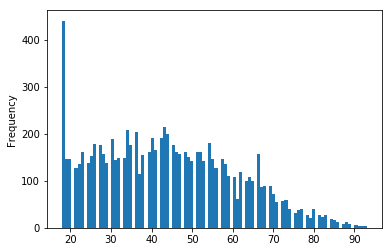

In [28]:
df[['c_id', 'c_age']].drop_duplicates().c_age.plot('hist', bins=100)
plt.plot()

on ajoute un flag 'age irrelevant'

In [29]:
df.loc[df.c_age == 18, 'data_info'] = 'age_irrelevant'

#### On exprime la date de différentes manières

In [30]:
# mois d'achat
df['t_month'] = df['t_date'].dt.month
# début, fin du mois ? 0,1,2,3
df['t_month_part'] = (df['t_date'].dt.day / (df['t_date'].dt.days_in_month/4+1)).apply(lambda x: str(x)[0])
# jour de la semaine
df['t_weekday'] = df['t_date'].dt.dayofweek
# heure d'achat
df['t_hour'] = df['t_date'].dt.hour

#### On discrétise le prix

In [31]:
def discretise_price(price):
    tranches = [
        {'bornes': (0,4),  'label': 'very_cheap 3-'},
        {'bornes': (4,10), 'label': 'cheap 4-9'},
        {'bornes': (10,20), 'label': 'medium 10-19'},
        {'bornes': (20,80), 'label': 'expensive 20-79'},
        {'bornes': (80,500), 'label': 'very_expansive 80+'}
    ]
    for t in tranches:
        if t['bornes'][0] <= price < t['bornes'][1]:
            return t['label']

In [32]:
df['p_price_range'] = df['p_price'].apply(discretise_price)

<hr>

#### Enfin, renommage des colonnes

In [33]:
df = df[[
    'c_id',
    'c_sex',
    'c_birth',
    'c_age',
    'c_age_range',
    
    'p_id',
    'p_cat',
    'p_price',
    'p_price_range',
    
    't_sess_id',
    't_buyer_age',
    't_buyer_age_range',
    
    't_date',
    't_hour',
    't_weekday',
    't_month_part',
    't_month',
    
    'data_info'
]]

# Projection et enregistrement

on créé 3 dataframe : 
- les produits invendus
- les cliens qui n'ont rien acheté
- toutes les transactions avec information des clients, 

In [34]:
produits_invendus = df.loc[df['p_id'].isin(p_invendus_id), ['p_id', 'p_cat', 'p_price', 'p_price_range']]

In [35]:
clients_sans_achat = df.loc[df['c_id'].isin(c_ss_achat_id), ['c_id', 'c_sex', 'c_birth', 'c_age', 'c_age_range']]

In [36]:
transactions = df.dropna(subset=['c_id', 'c_sex', 'c_birth', 'c_age', 'c_age_range', 'p_id', 'p_cat',
       'p_price', 'p_price_range', 't_sess_id', 't_buyer_age',
       't_buyer_age_range', 't_date', 't_hour', 't_weekday', 't_month_part',
       't_month'])

#### Enregistrement des données

In [37]:
produits_invendus.to_csv('3_clean_dataset/produits_invendus.csv', index=False)
clients_sans_achat.to_csv('3_clean_dataset/clients_sans_achat.csv', index=False)
transactions.to_csv('3_clean_dataset/transactions.csv', index=False)